In [2]:
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_2086.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_605.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_1719.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_1318.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_2590.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_2245.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_2461.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_278.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_877.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_881.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_837.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_2301.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_1055.png
/kaggle/input/mydataset/DATASET/Augmented_Dataset/images/aug_475.png
/kaggle/input/mydataset/DA

In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from glob import glob

# Taille des images
H, W = 256, 256

# 1. Définir l'architecture UNet
def conv_block(inputs, num_filters, dropout_rate=0.2):
    # Première couche de convolution avec Dropout
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)  # Appliquer Dropout après la première couche Conv2D

    # Deuxième couche de convolution avec Dropout
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)  # Appliquer Dropout après la deuxième couche Conv2D

    return x

def encoder_block(inputs, num_filters, dropout_rate=0.2):
    # Bloc encodeur avec convolution et MaxPooling
    x = conv_block(inputs, num_filters, dropout_rate)
    p = MaxPool2D((2, 2))(x)  # MaxPooling pour réduire les dimensions spatiales
    return x, p

def decoder_block(inputs, skip_features, num_filters, dropout_rate=0.2):
    # Bloc décodeur avec convolution transposée et connexions résiduelles (skip connections)
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])  # Concaténer les caractéristiques provenant de l'encodeur
    x = conv_block(x, num_filters, dropout_rate)  # Appliquer à nouveau la convolution avec Dropout
    return x

def build_unet(input_shape, dropout_rate=0.2):
    inputs = Input(input_shape)

    # Encodeur avec des filtres croissants
    s1, p1 = encoder_block(inputs, 16, dropout_rate)
    s2, p2 = encoder_block(p1, 32, dropout_rate)
    s3, p3 = encoder_block(p2, 64, dropout_rate)
    s4, p4 = encoder_block(p3, 128, dropout_rate)

    # Partie centrale (Bottleneck)
    b1 = conv_block(p4, 256, dropout_rate)

    # Décodeur avec des filtres décroissants et connexions résiduelles
    d1 = decoder_block(b1, s4, 128, dropout_rate)
    d2 = decoder_block(d1, s3, 64, dropout_rate)
    d3 = decoder_block(d2, s2, 32, dropout_rate)
    d4 = decoder_block(d3, s1, 16, dropout_rate)

    # Couche de sortie avec activation sigmoid pour la segmentation binaire
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

# 2. Charger les données
def load_data(image_dir, mask_dir):
    # Charger les images et masques dans un ordre trié depuis les répertoires
    images = sorted(glob(os.path.join(image_dir, "*.png")))
    masks = sorted(glob(os.path.join(mask_dir, "*.png")))
    return images, masks

def read_image(path):
    # Lire et prétraiter l'image
    x = load_img(path, target_size=(H, W), color_mode="rgb")
    x = img_to_array(x) / 255.0  # Normaliser l'image dans la plage [0, 1]
    return x

def read_mask(path):
    # Lire et prétraiter le masque (en niveaux de gris)
    x = load_img(path, target_size=(H, W), color_mode="grayscale")
    x = img_to_array(x) / 255.0  # Normaliser le masque dans la plage [0, 1]
    return x

def tf_dataset(images, masks, batch_size):
    def parse_data(image, mask):
        # Prétraiter l'image et le masque en utilisant les fonctions définies ci-dessus
        x = read_image(image.decode())
        y = read_mask(mask.decode())
        return x, y

    # Créer un dataset TensorFlow à partir des images et des masques
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    
    # Utiliser tf.py_function pour envelopper les étapes de prétraitement
    dataset = dataset.map(lambda image, mask: tf.py_function(
        parse_data, [image, mask], [tf.float32, tf.float32]),
        num_parallel_calls=tf.data.AUTOTUNE)  # Utiliser AUTOTUNE pour le traitement parallèle
    
    # Batch et préchargement des données pour une meilleure performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from glob import glob

# Taille des images
H, W = 256, 256

# 1. Définir l'architecture UNet
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    # Bottleneck
    b1 = conv_block(p4, 256)

    # Decoder
    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

# 2. Charger les données
def load_data(image_dir, mask_dir):
    images = sorted(glob(os.path.join(image_dir, "*.png")))
    masks = sorted(glob(os.path.join(mask_dir, "*.png")))
    return images, masks

def read_image(path):
    x = load_img(path, target_size=(H, W), color_mode="rgb")
    x = img_to_array(x) / 255.0
    return x

def read_mask(path):
    x = load_img(path, target_size=(H, W), color_mode="grayscale")
    x = img_to_array(x) / 255.0
    return x

def tf_dataset(images, masks, batch_size):
    def parse_data(image, mask):
        x = read_image(image.decode())
        y = read_mask(mask.decode())
        return x, y

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(lambda x, y: tf.numpy_function(parse_data, [x, y], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(4)
    return dataset

# 3. Fonction de perte et métriques personnalisées
smooth = 1e-15

# F1-score calculation
def f1(y_true, y_pred, smooth=1e-15):
    y_true_f = tf.reshape(y_true, [-1])  # Flatten the tensor
    y_pred_f = tf.reshape(y_pred, [-1])  # Flatten the tensor
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    precision = intersection / (tf.reduce_sum(y_pred_f) + smooth)
    recall = intersection / (tf.reduce_sum(y_true_f) + smooth)
    return 2 * ((precision * recall) / (precision + recall + smooth))
    
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# 4. Configuration des chemins
train_image_dir = "/kaggle/input/mydataset/DATASET/Augmented_Dataset/train/images"
train_mask_dir = "/kaggle/input/mydataset/DATASET/Augmented_Dataset/train/masks"
valid_image_dir = "/kaggle/input/mydataset/DATASET/Augmented_Dataset/valid/images"
valid_mask_dir = "/kaggle/input/mydataset/DATASET/Augmented_Dataset/valid/masks"

train_images, train_masks = load_data(train_image_dir, train_mask_dir)
valid_images, valid_masks = load_data(valid_image_dir, valid_mask_dir)

train_images, train_masks = shuffle(train_images, train_masks, random_state=42)

# 5. Préparer les datasets TensorFlow
batch_size = 16
train_dataset = tf_dataset(train_images, train_masks, batch_size)
valid_dataset = tf_dataset(valid_images, valid_masks, batch_size)

# 6. Construire et compiler le modèle
model = build_unet((H, W, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coef, iou, Recall(), Precision(),f1])

# 7. Callbacks
model_path = "files/unet_model.keras"


In [6]:
for batch in train_dataset.take(1):
    train_images, train_masks = batch
    print("Forme des données d'entraînement :", train_images.shape, train_masks.shape)

for batch in valid_dataset.take(1):
    valid_images, valid_masks = batch
    print("Forme des données de validation :", valid_images.shape, valid_masks.shape)

Forme des données d'entraînement : (16, 256, 256, 3) (16, 256, 256, 1)
Forme des données de validation : (16, 256, 256, 3) (16, 256, 256, 1)


Vérification des datasets :
Forme des images d'entraînement : (16, 256, 256, 3)
Forme des masques d'entraînement : (16, 256, 256, 1)
Valeurs minimales et maximales des images d'entraînement : 0.0, 1.0
Valeurs minimales et maximales des masques d'entraînement : 0.0, 1.0
Forme des images de validation : (16, 256, 256, 3)
Forme des masques de validation : (16, 256, 256, 1)
Valeurs minimales et maximales des images de validation : 0.03529411926865578, 1.0


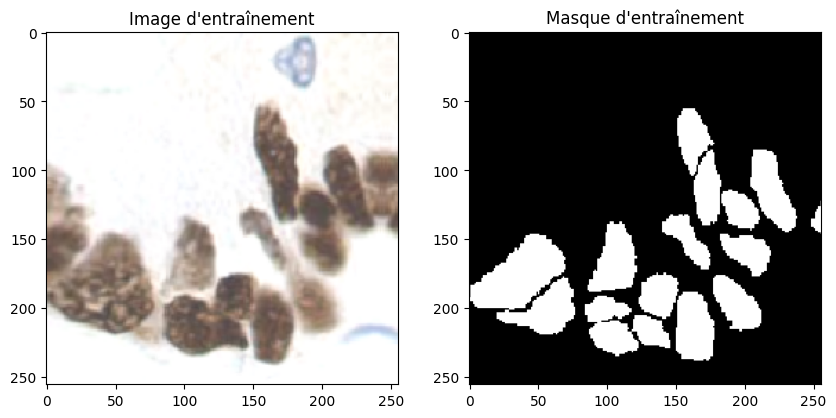

Vérification du modèle :


Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

Loss Function: <function dice_loss at 0x7ec1df13edd0>
Optimizer: <keras.src.optimizers.adam.Adam object at 0x7ec1e170ac50>
Metrics: ['loss', 'compile_metrics']


In [7]:
print("Vérification des datasets :")
for batch in train_dataset.take(1):
    train_images, train_masks = batch
    print(f"Forme des images d'entraînement : {train_images.shape}")
    print(f"Forme des masques d'entraînement : {train_masks.shape}")
    print(f"Valeurs minimales et maximales des images d'entraînement : {train_images.numpy().min()}, {train_images.numpy().max()}")
    print(f"Valeurs minimales et maximales des masques d'entraînement : {train_masks.numpy().min()}, {train_masks.numpy().max()}")
for batch in valid_dataset.take(1):  # Prenez un batch de validation
    valid_images, valid_masks = batch
    print(f"Forme des images de validation : {valid_images.shape}")
    print(f"Forme des masques de validation : {valid_masks.shape}")
    print(f"Valeurs minimales et maximales des images de validation : {valid_images.numpy().min()}, {valid_images.numpy().max()}")

# Afficher un exemple
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0].numpy())
plt.title("Image d'entraînement")
plt.subplot(1, 2, 2)
plt.imshow(train_masks[0].numpy().squeeze(), cmap="gray")
plt.title("Masque d'entraînement")
plt.show()

# Vérification du modèle
print("Vérification du modèle :")
model.summary()
print("Loss Function:", model.loss)
print("Optimizer:", model.optimizer)
print("Metrics:", model.metrics_names)

In [9]:
model.compile(optimizer=Adam(learning_rate=3e-4), loss=dice_loss, metrics=[dice_coef, iou, Recall(), Precision(),f1])
model.summary()  # Affiche la structure du modèle

print("Loss Function:", model.loss)  # Affiche la fonction de perte
print("Optimizer:", model.optimizer)  # Affiche l'optimiseur
print("Metrics:", model.metrics_names)  # Affiche les métriques configurées

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

Loss Function: <function dice_loss at 0x7ec1df13edd0>
Optimizer: <keras.src.optimizers.adam.Adam object at 0x7ec1df141ab0>
Metrics: ['loss', 'compile_metrics']


In [ ]:
import os
import numpy as np
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define U-Net blocks with Dropout
def conv_block(inputs, num_filters, dropout_rate=0.2):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)  # Apply Dropout after each convolution layer

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)  # Apply Dropout after each convolution layer

    return x

def encoder_block(inputs, num_filters, dropout_rate=0.2):
    x = conv_block(inputs, num_filters, dropout_rate)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, dropout_rate=0.2):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate)
    return x

def build_unet(input_shape, dropout_rate=0.2):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 16, dropout_rate)
    s2, p2 = encoder_block(p1, 32, dropout_rate)
    s3, p3 = encoder_block(p2, 64, dropout_rate)
    s4, p4 = encoder_block(p3, 128, dropout_rate)

    # Bottleneck
    b1 = conv_block(p4, 256, dropout_rate)

    # Decoder
    d1 = decoder_block(b1, s4, 128, dropout_rate)
    d2 = decoder_block(d1, s3, 64, dropout_rate)
    d3 = decoder_block(d2, s2, 32, dropout_rate)
    d4 = decoder_block(d3, s1, 16, dropout_rate)

    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

# F1-score calculation
def f1(y_true, y_pred, smooth=1e-15):
    y_true_f = tf.reshape(y_true, [-1])  # Flatten the tensor
    y_pred_f = tf.reshape(y_pred, [-1])  # Flatten the tensor
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    precision = intersection / (tf.reduce_sum(y_pred_f) + smooth)
    recall = intersection / (tf.reduce_sum(y_true_f) + smooth)
    return 2 * ((precision * recall) / (precision + recall + smooth))

# Jaccard Loss Function with updated syntax
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.reduce_sum(tf.abs(y_true) + tf.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

# Dice Coefficient with updated syntax
def dice_coef(y_true, y_pred, smooth=1e-15):
    y_true_f = tf.reshape(y_true, [-1])  # Flatten the tensor using reshape
    y_pred_f = tf.reshape(y_pred, [-1])  # Flatten the tensor using reshape
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# IoU Function with updated syntax
def iou(y_true, y_pred, eps=1e-15):
    y_true_f = tf.reshape(y_true, [-1])  # Flatten the tensor using reshape
    y_pred_f = tf.reshape(y_pred, [-1])  # Flatten the tensor using reshape
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + eps) / (union + eps)

# Load and prepare the datasets
def load_data(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)])
    return image_paths, mask_paths

def preprocess_images(images, masks, img_size):
    X = np.array([cv2.resize(cv2.imread(img), img_size) / 255.0 for img in images]).astype(np.float32)
    Y = np.array([cv2.resize(cv2.imread(mask, cv2.IMREAD_GRAYSCALE), img_size) / 255.0 for mask in masks]).astype(np.float32)
    Y = np.expand_dims(Y, axis=-1)
    return X, Y

# Load augmented data
image_dir = "/kaggle/input/mydataset/DATASET/Augmented_Dataset/images"
mask_dir = "/kaggle/input/mydataset/DATASET/Augmented_Dataset/masks"
images, masks = load_data(image_dir, mask_dir)

# Shuffle and split the data
images, masks = shuffle(images, masks, random_state=42)
split = int(0.8 * len(images))
train_images, valid_images = images[:split], images[split:]
train_masks, valid_masks = masks[:split], masks[split:]

# Preprocess the images
img_size = (256, 256)
X_train, Y_train = preprocess_images(train_images, train_masks, img_size)
X_valid, Y_valid = preprocess_images(valid_images, valid_masks, img_size)

# Create TensorFlow datasets
batch_size = 2
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build and compile the model
input_shape = (256, 256, 3)
model = build_unet(input_shape, dropout_rate=0.2)  # Pass dropout_rate parameter
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=jaccard_distance_loss,
    metrics=[dice_coef, iou, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), f1]
)

# Set up callbacks
callbacks = [
    ModelCheckpoint("unet_model.keras", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

# Training the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,  # Set number of epochs
    callbacks=callbacks,
    verbose=1
)

In [1]:
# Save the model
model.save("trained_unet_model.h5")

NameError: name 'model' is not defined

In [14]:
# Evaluate the model
results = model.evaluate(valid_dataset, verbose=1)
print(f"Loss: {results[0]}")
print(f"Dice Coefficient: {results[1]}")
print(f"IoU: {results[2]}")
print(f"Recall: {results[3]}")
print(f"Precision: {results[4]}")
print(f"F1-score: {results[5]}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - dice_coef: 0.3341 - f1: 0.3341 - iou: 0.2005 - loss: 0.4446 - precision_3: 0.8476 - recall_3: 0.1800
Loss: 0.44473928213119507
Dice Coefficient: 0.3338843882083893
IoU: 0.20040223002433777
Recall: 0.17707432806491852
Precision: 0.8468679189682007
F1-score: 0.33388444781303406


KeyError: 'f1_score'

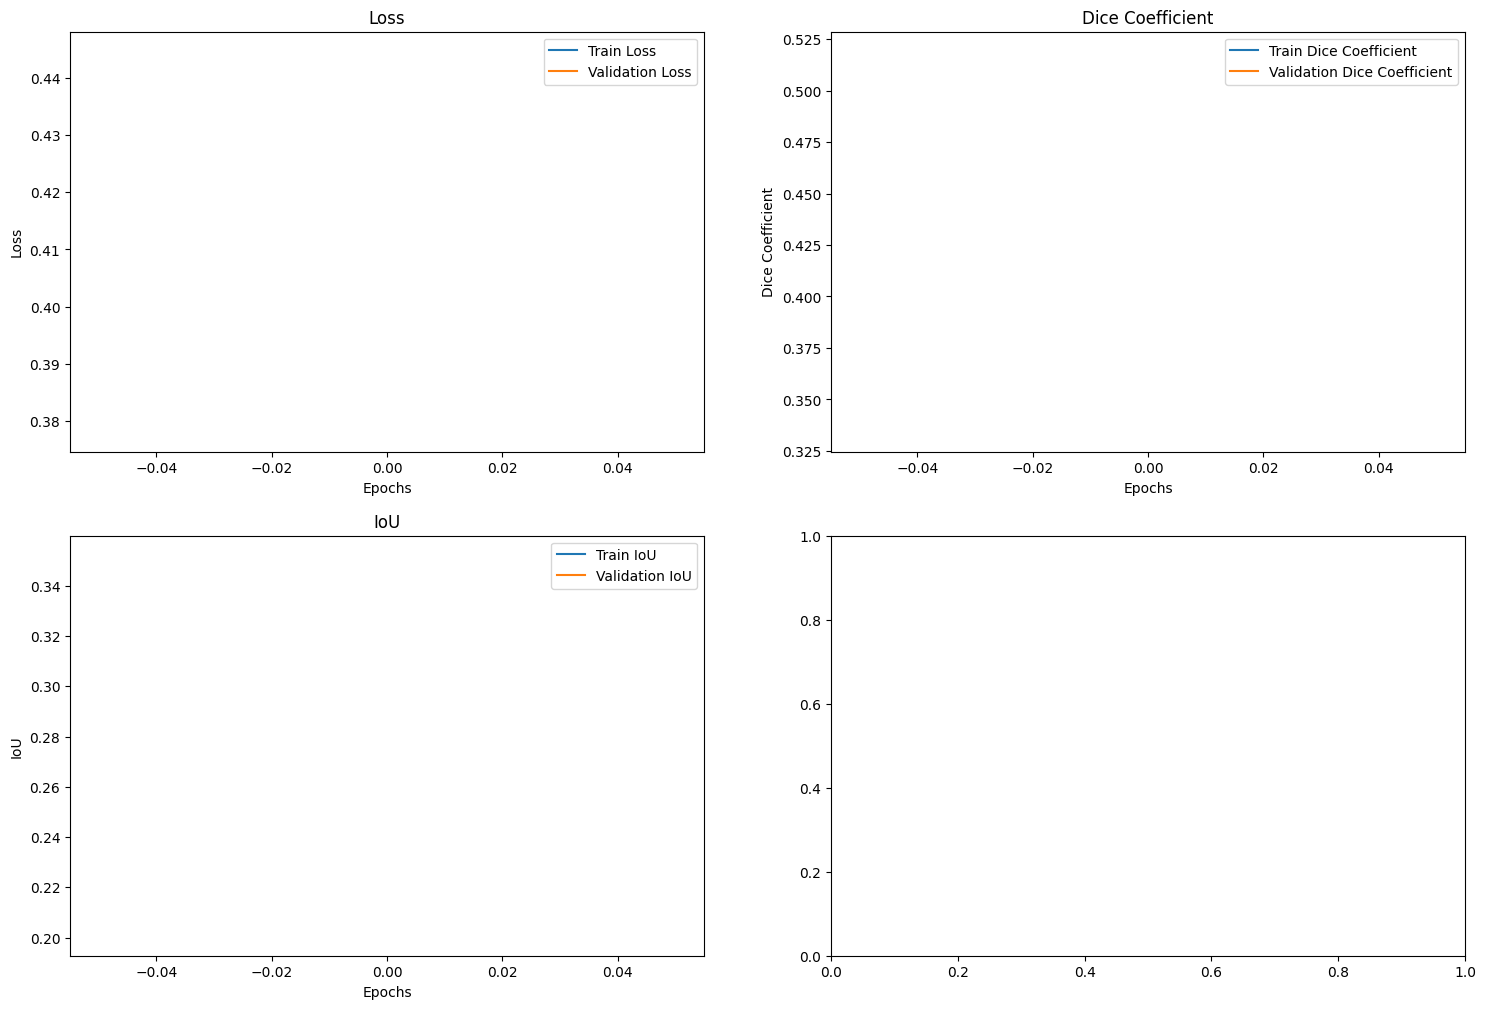

In [16]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    plt.figure(figsize=(18, 12))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Dice Coefficient
    plt.subplot(2, 2, 2)
    plt.plot(history.history["dice_coef"], label="Train Dice Coefficient")
    plt.plot(history.history["val_dice_coef"], label="Validation Dice Coefficient")
    plt.title("Dice Coefficient")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.legend()

    # Plot IoU
    plt.subplot(2, 2, 3)
    plt.plot(history.history["iou"], label="Train IoU")
    plt.plot(history.history["val_iou"], label="Validation IoU")
    plt.title("IoU")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.legend()

    # Plot F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(history.history["f1_score"], label="Train F1 Score")
    plt.plot(history.history["val_f1_score"], label="Validation F1 Score")
    plt.title("F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [ ]:
# Predict and visualize
def visualize_predictions(model, X, Y, num_samples=5):
    preds = model.predict(X)
    preds = (preds > 0.5).astype(np.float32)  # Threshold predictions

    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[i])
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize some samples
visualize_predictions(model, X_valid[:5], Y_valid[:5])